In [ ]:
# EMAIL SPAM DETECTION
#IMPORT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

In [ ]:

dt = pd.read_csv("/content/sample_data/spam_ham_dataset.csv")

In [ ]:
dt.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [ ]:
dt.describe()

,Unnamed: 0,label_num
count,5171.000000,5171.000000
mean,2585.000000,0.289886
std,1492.883452,0.453753
min,0.000000,0.000000
25%,1292.500000,0.000000
50%,2585.000000,0.000000
75%,3877.500000,1.000000
max,5170.000000,1.000000


In [ ]:
dt.info()
#Check for null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [ ]:
dt = dt.drop('Unnamed: 0', axis=1)

In [ ]:
dt['label'].value_counts()

ham     3672
spam    1499
Name: label, dtype: int64

In [ ]:
# Tokenization
import nltk
nltk.download('punkt')
def tokenize(text):
  """Tokenizes the given text.
  Args:
    text: A string containing the text to be tokenized.
  Returns:
    A list of tokens.
  """
  # Split the text into words and other tokens
  tokens = nltk.word_tokenize(text)
  return tokens

# Tokenize the text column of the DataFrame
dt['tokenized_text'] = dt['text'].apply(tokenize)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import nltk
nltk.download('stopwords')
# Preprocess the data
# Remove punctuation and stop words
dt['text'] = dt['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in nltk.corpus.stopwords.words('english') and not word.isalnum()]))
# Convert the text column to lowercase
dt['text'] = dt['text'].str.lower()
# Convert the label column to a numerical variable
dt['label_num'] = dt['label'].map({'spam': 1, 'ham': 0})

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Remove special characters from the Series object using the re.sub() method
dt['text'] = dt['text'].str.replace(r'[^\w\s]', '')
# Remove hyperlinks from the Series object using the re.sub() method
dt['text'] = dt['text'].str.replace(r'http[^\s]*', '')
# Display the top results
dt.head()

<ipython-input-16-2bf797c46add>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  dt['text'] = dt['text'].str.replace(r'[^\w\s]', '')
<ipython-input-16-2bf797c46add>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  dt['text'] = dt['text'].str.replace(r'http[^\s]*', '')


,label,text,label_num
0,ham,subject,0
1,ham,subject,0
2,ham,subject ...,0
3,spam,subject,1
4,ham,subject,0


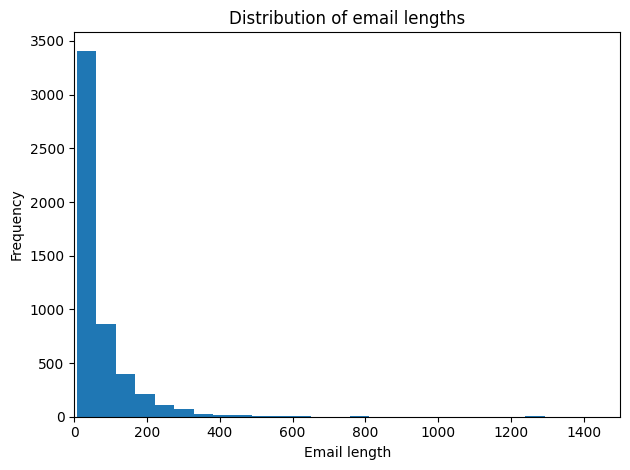

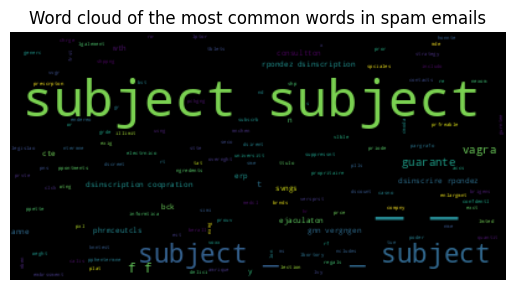

In [ ]:
# EDA
from wordcloud import WordCloud
# Create a histogram of the length of the emails
plt.hist(dt['text'].str.len(), bins=100)
plt.xlabel('Email length')
plt.ylabel('Frequency')
plt.title('Distribution of email lengths')
plt.xlim(left=0, right=1500)
plt.tight_layout()
plt.show()
# Create a word cloud of the most common words in spam emails
spam_words = dt[dt['label_num'] == 1]['text'].str.cat(sep=' ')
wordcloud = WordCloud().generate(spam_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word cloud of the most common words in spam emails')
plt.show()



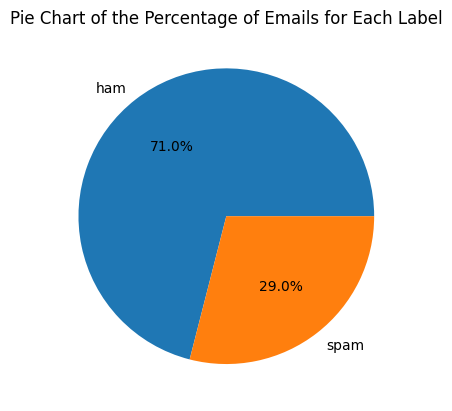

In [ ]:

# Percentage of emails for each label
label_counts = dt['label'].value_counts().sort_values(ascending=False)
label_percentages = label_counts / len(dt) * 100

# Pie chart of the label percentages
plt.pie(label_percentages, labels=label_counts.index, autopct='%1.1f%%')
plt.title('Pie Chart of the Percentage of Emails for Each Label')
plt.show()


In [ ]:
# Class imbalance in the dataset, with a majority of instances labeled as 'ham' and a minority labeled as 'spam'
# Can lead to biased predictions and lower accuracy for models

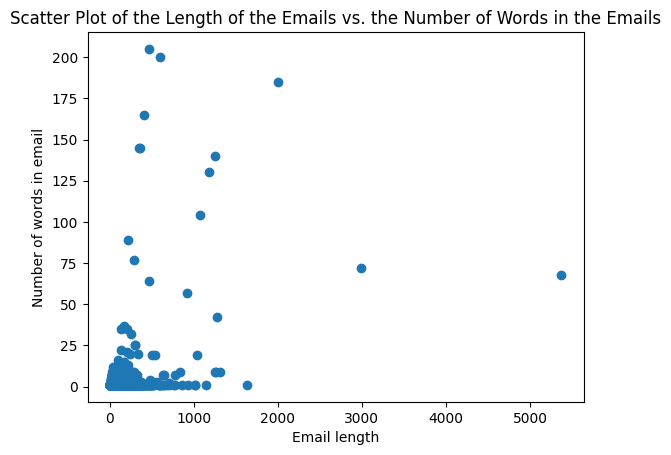

In [ ]:
# Get the length and number of words for each email
email_lengths = dt['text'].str.len()
email_word_counts = dt['text'].str.split().str.len()

# Create a scatter plot of the email lengths vs. the number of words in the emails
plt.scatter(email_lengths, email_word_counts)
plt.xlabel('Email length')
plt.ylabel('Number of words in email')
plt.title('Scatter Plot of the Length of the Emails vs. the Number of Words in the Emails')
plt.show()


In [ ]:
# MODEL
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE  # To oversample

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(dt['text'])

# TRAIN TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, dt['label'], test_size=0.25)

# Oversample to increase accuracy
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

# Train the model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Test the model
y_pred = clf.predict(X_test)
acc_LR = np.mean(y_pred == y_test)
print('LR_MODEL Accuracy:', acc_LR)



LR_MODEL Accuracy: 0.7432327919566899


In [ ]:
# Classification report
from sklearn.metrics import classification_report
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.74      1.00      0.85       952
        spam       1.00      0.03      0.05       341

    accuracy                           0.74      1293
   macro avg       0.87      0.51      0.45      1293
weighted avg       0.81      0.74      0.64      1293



In [ ]:
from sklearn.svm import SVC
# Train the model
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
# Evaluate the model
y_pred = clf.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print('SVC_MODEL Accuracy :', accuracy)

SVC_MODEL Accuracy : 0.7432327919566899


In [ ]:
from sklearn.metrics import classification_report
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.74      1.00      0.85       952
        spam       1.00      0.03      0.05       341

    accuracy                           0.74      1293
   macro avg       0.87      0.51      0.45      1293
weighted avg       0.81      0.74      0.64      1293



In [ ]:
# Overall, the model's performance is better for 'ham' emails compared to 'spam' emails.